In [2]:
import pandas as pd
import numpy as np

from funcs.ad import aggregate_pvalues, get_sigma_values

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from astropy import units as u
from astropy.constants import R_sun

import seaborn as sns


def colorcode_rotation(st_rotp):
    """Define color code and symbol marker for rotation period.

    Parameters
    ----------
    st_rotp : float
        Rotation period in days.

    Returns
    -------
    color : str
        Color code.
    marker : str
        Symbol marker.
    """
    if st_rotp < 10.:
        color = "green"
        symbol = "o"

    elif (st_rotp >= 10.) & (st_rotp < 15.):
        color = "blue"
        symbol = "x"

    elif (st_rotp >= 15.):
        color = "black"
        symbol = "d"

    else:
        color = "lightgrey"
        symbol = "s"

    return color, symbol


def obstime(n, mission):
    if n > 50000:
        if mission == "TESS":
            return n / 3. / 60. / 24.  # 20 sec cadence
        elif mission == "Kepler":
            return n / 60. / 24.  # 1 min cadence
    else:
        if mission == "TESS":
            return n * 2. / 60. / 24.  # 2 min cadence
        elif mission == "Kepler":
            return n / 60. / 24.  # 1 min cadence
        else:
            raise ValueError(
                f"{n} data points for {mission} is not enough to calculate the observation time")


In [3]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv(
    "../results/params_of_star_planet_systems_with_AD_tests.csv")

# rename column tic_id to TIC
sps_w_ad.rename(columns={"tic_id": "TIC"}, inplace=True)
sps_w_ad.rename(columns={"st_rad_kepler": "st_rad"}, inplace=True)

# fill missing st_rad values with st_rad_tess
sps_w_ad.st_rad.fillna(sps_w_ad.st_rad_tess, inplace=True)

# read in non-transiting system table
sps_w_ad_rv = pd.read_csv(
    "../data/2022_11_15_input_catalog_NONtransit_star_planet_systems.csv")

# concat the two tables
sps_w_ad = pd.concat([sps_w_ad, sps_w_ad_rv], axis=0)

# read in age and rotation period from the literature search
literature_params = pd.read_csv(
    "../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

# aggregate the p-values
mean_std = aggregate_pvalues(adtests, subsample="ED>1s", period="orbit")

# merge the AD test results with the stellar parameters
mean_std = mean_std.merge(literature_params, on=["TIC"], how="left")

# define the colors and symbols for the different rotation periods
mean_std["color"], mean_std["symbol"] = zip(
    *mean_std.st_rotp.apply(colorcode_rotation))

# add semi-major axis in AU to the table


def g(x): return sps_w_ad[sps_w_ad.TIC.astype(
    str) == str(x)].pl_orbsmax.values[0]


mean_std["a_au"] = mean_std.TIC.apply(g)


In [4]:
def b_from_lx_reiners(lx, r):
    """Reiners et al. 2022 Eq. 4
    
    Parameters
    ----------
    lx : float
        X-ray luminosity in erg/s.
    r : float
        Stellar radius in R_sun.
    """
    rcm = (r.to(u.cm)).value
    
    B =  np.power(lx / 3.28e-12, 1. / 1.58) / (4. * np.pi * rcm**2) 
    return B

In [5]:
def h(x): return sps_w_ad[sps_w_ad.TIC.astype(
    str) == str(x)].st_rad.values[0]


mean_std["st_rad"] = mean_std.TIC.apply(h)

def j(x): return sps_w_ad[sps_w_ad.TIC.astype(
    str) == str(x)].pl_radj.values[0]


mean_std["pl_radj"] = mean_std.TIC.apply(j)

params = pd.read_csv("../results/2022_08_stellar_params.csv")
params.TIC = params.TIC.astype(str)
mean_std = mean_std.merge(params[["TIC","xray_flux_erg_s"]], on=["TIC"], how="left")



In [6]:

mean_std["B_G"] = mean_std.apply(lambda x: b_from_lx_reiners(x.xray_flux_erg_s, x.st_rad * R_sun), axis=1)


In [7]:
# get the flare table
flares = pd.read_csv("../results/2022_07_flares_vetted.csv")

# calculate time covered by the observations,
# get orbital period from either Kepler or TESS, and
# calculate the number of orbits covered by the observations

# initialize empty lists
orbits_covered = []
orbpers = []
obstimes_d = []

# loop over all star-planet systems
for sys, row in mean_std.iterrows():

    # get total observing time per system
    sysvalues = flares[flares.TIC.astype(str) == str(row.TIC)]
    vals = sysvalues[["total_n_valid_data_points",
                      "mission"]].drop_duplicates()

    obstime_d = vals.apply(lambda x: obstime(
        x.total_n_valid_data_points, x.mission), axis=1).sum()

    # get orbital period
    sysvalues = sps_w_ad[sps_w_ad.TIC.astype(str) == str(row.TIC)]
    orbper = sysvalues.pl_orbper_kepler.values[0]
    if np.isnan(orbper):
        orbper = sysvalues.pl_orbper_tess.values[0]

    orbpers.append(orbper)
    obstimes_d.append(obstime_d)
    orbits_covered.append(obstime_d / orbper)

# add to dataframe
mean_std["orbits_covered"] = orbits_covered
mean_std["orbper_d"] = orbpers
mean_std["obstime_d"] = obstimes_d


In [8]:
# calculate relative velocity between stellar rotation at the planetary orbit
# and the orbital velocity of the planet
# in km/s
mean_std["v_rel_km_s"] = (2 * np.pi * mean_std.a_au *
                                (1/mean_std.orbper_d - 1/mean_std.st_rotp) /
                                 24. / 3600. * 149597870.700)


In [9]:
# calculate P_SPI using Lanza 2012 and Lanza 2009 relation

def p_spi_lanza12(v_rel, B, pl_rad):
    """Lanza 2012
    
    Parameters
    ----------
    v_rel : float
        Relative velocity between stellar rotation and orbital velocity in km/s.
    B : float
        X-ray luminosity in erg/s.
    pl_rad : float
        Planet radius in R_jup.
    """
    return B**(4./3.) * v_rel * pl_rad**2

In [10]:
mean_std["p_spi"] = mean_std.apply(lambda x: p_spi_lanza12(np.abs(x.v_rel_km_s), x.B_G, x.pl_radj), axis=1)

In [11]:
mean_std[["ID","pl_radj","st_rad","xray_flux_erg_s","p_spi","v_rel_km_s","orbper_d","st_rotp"]].dropna(subset=["xray_flux_erg_s"])

,ID,pl_radj,st_rad,xray_flux_erg_s,p_spi,v_rel_km_s,orbper_d,st_rotp
0,Kepler-1627,0.329,0.84,4.649198e+29,6.626250e+05,-172.458584,7.202837,2.5949
6,HIP 67522,0.898,1.38,3.414579e+30,1.905049e+07,-464.866306,6.959503,1.4200
8,TOI-540,0.081,0.19,8.077696e+27,3.043067e+04,-75.867701,1.239149,0.7261
9,GJ 3082,0.249,0.47,4.813158e+27,1.297093e+04,-59.286948,11.949000,6.5500
10,GJ 674,0.297,0.36,3.409800e+27,3.705862e+04,78.217764,4.693800,34.8500
11,GJ 687,0.385,0.42,8.958095e+26,2.893462e+03,16.936936,38.142000,60.0000
18,HAT-P-11,0.389,0.68,3.104208e+27,1.331007e+04,96.643513,4.887802,28.1600
20,L 98-59,0.076,0.30,3.412282e+26,7.437324e+02,102.845155,2.253114,80.9000
21,Proxima Cen,0.096,0.14,6.521725e+26,6.208477e+03,40.812151,11.186000,83.0000
23,DS Tuc A,0.509,0.96,7.161916e+29,1.828545e+06,-197.137271,8.138268,2.8500


In [12]:
# ------------------------------------------------------------
# Plotting setup
# get reference sigma values
sigmas, sigma_labels = get_sigma_values()

# define legend elements
legend = [Line2D([0], [0], marker='X', color='w',
          markerfacecolor='blue', markersize=10),
          Line2D([0], [0], marker='d', color='w',
          markerfacecolor='black', markersize=10),
          Line2D([0], [0], marker='o', color='w',
          markerfacecolor='green', markersize=10),
          Line2D([0], [0], marker='s', color='w',
          markerfacecolor='lightgrey', markersize=10)]

# define legend labels
labels = [r"$10 \leq P_{rot} < 15$ d",
          r"$P_{rot} \geq 15$ d",
          r"$P_{rot} < 10$ d",
          r"no $P_{rot}$"]

# ------------------------------------------------------------

In [13]:
from adjustText import adjust_text

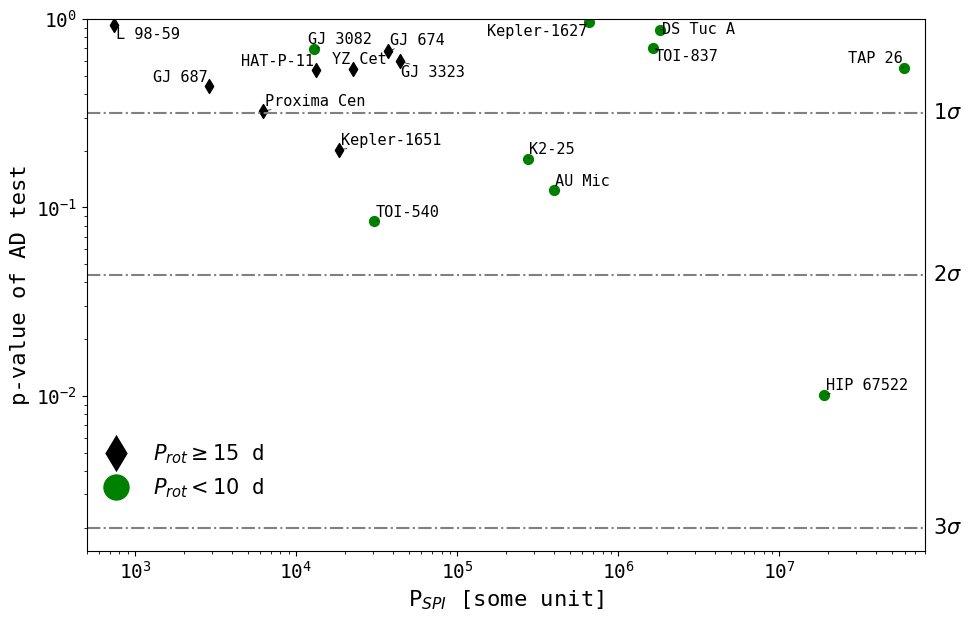

In [19]:
# P-VALUE VS. SEMI-MAJOR AXIS

# set up figure
fig, ax = plt.subplots(figsize=(10, 6.5))

data = mean_std[mean_std.p_spi.notnull()]

texts = []

# plot the data
for color, group in data.groupby("color"):
    plt.scatter(group["p_spi"], group["mean"], marker=group["symbol"].iloc[0],
                c=color, s=50., alpha=1.)
    for star, row in group.iterrows():
        texts.append(plt.text(x=row["p_spi"], y=row["mean"], s=row["ID"],
                    fontsize=11, ha="right", va="top", rotation=0))
    # if (color != "lightgrey") & (color != "blue"):
    #     sns.kdeplot(data=group, x="p_spi", y="mean", fill=True,
    #                 color=color, common_norm=True, alpha=.4, log_scale=True,
    #                 cut=0., levels=[0.32, 0.68, 0.95, 0.997])


# log scale
plt.yscale("log")
plt.xscale("log")

# # add sigma lines
for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(9e7, sigma, label, fontsize=15,
             color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("P$_{SPI}$ [some unit]")

# legend
plt.legend(legend[1:3], labels[1:3], loc=(0, 0.08), fontsize=15)

# limits
plt.xlim(5e2, 8e7)
plt.ylim(1.5e-3, 1)

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
# save figure
plt.savefig("../results/plots/2022_11_22_adtests_vs_pspi_kde.png",
            dpi=300)


# ------------------------------------------------------------


In [ ]:
# P-VALUE VS. SEMI-MAJOR AXIS

# set up figure
fig, ax = plt.subplots(figsize=(10, 6.5))


# plot the data
for color, group in mean_std.groupby("color"):
    plt.scatter(group["a_au"], group["mean"], marker=group["symbol"].iloc[0],
                c=color, s=90., alpha=1.)
    if (color != "lightgrey") & (color != "blue"):
        sns.kdeplot(data=group, x="a_au", y="mean", fill=True,
                    color=color, common_norm=True, alpha=.4, log_scale=True,
                    cut=0., levels=[0.32, 0.68, 0.95, 0.997])


# log scale
plt.yscale("log")
plt.xscale("log")

# add sigma lines
for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(.3, sigma, label, fontsize=15,
             color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("semi-major axis (AU)")

# legend
plt.legend(legend, labels, loc=(0, 0.08), fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_vs_semimajor_axis_kde.png",
            dpi=300)

# ------------------------------------------------------------


In [ ]:
# P-VALUE VS. SEMI-MAJOR AXIS

# set up figure
fig, ax = plt.subplots(figsize=(10, 6.5))

mean_std["vrellog"] = np.sign(mean_std.v_rel_km_s) * np.log10(
                                                np.abs(mean_std.v_rel_km_s))
# plot the data
for color, group in mean_std.groupby("color"):
    plt.scatter(group["vrellog"], group["mean"], marker=group["symbol"].iloc[0],
                c=color, s=90., alpha=1.)
    if (color != "lightgrey") & (color != "blue"):
        sns.kdeplot(data=group, x="vrellog", y="mean", fill=True,
                    color=color, common_norm=True, alpha=.4, #log_scale=True,
                    cut=0., levels=[0.32, 0.68, 0.95, 0.997])


# log scale
plt.yscale("log")
# plt.xscale("log")

# # add sigma lines
# for sigma, label in list(zip(sigmas, sigma_labels)):
#     plt.axhline(sigma, color="grey", linestyle="-.")
#     plt.text(1900, sigma, label, fontsize=15,
#              color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("log relative velocity [km/s]")

# limits
# plt.xlim(3, 1800)
plt.ylim(1.5e-3, 1)

# legend
plt.legend(legend, labels, loc=(.7, 0.08), fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_vs_vrel_kde.png",
            dpi=300)

# ------------------------------------------------------------


In [ ]:
minper, maxper = mean_std.orbper_d.min(), mean_std.orbper_d.max()

# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))

bins = np.logspace(np.log10(minper), np.log10(maxper), 20)

for color, group in mean_std.groupby("color"):
    # plt.hist(group.orbper_d, color=color, bins=bins)
    if color != "lightgrey":
        sns.kdeplot(data=group, x="orbper_d",
                    fill=True, alpha=0.4, color=color)

plt.xscale("log")
# plt.yscale("log")
plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
# plt.xlabel("rotation period [days]")
plt.xlabel("orbital period [days]")


In [ ]:
minflares, maxflares = mean_std.number_of_flares.min(), mean_std.number_of_flares.max()

# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))

for color, group in mean_std.groupby("color"):
    # plt.hist(group.orbper_d, color=color, bins=bins)
    if color != "lightgrey":
        sns.kdeplot(data=group, x="number_of_flares",
                    fill=True, alpha=0.3, color=color)


# plt.xscale("log")
# plt.yscale("log")
plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
plt.xlabel("number of flares")
plt.ylabel("density")


In [ ]:
# define legend elements
legend = [Line2D([0], [0], marker='', color='black',
          markerfacecolor='black', markersize=10),
          Line2D([0], [0], marker='', color='blue',
          markerfacecolor='blue', markersize=10),
          Line2D([0], [0], marker='', color='green',
          markerfacecolor='green', markersize=10), ]

# define legend labels
labels = [r"$P_{rot} \geq 15$ d",
          r"$10 \leq P_{rot} < 15$ d",
          r"$P_{rot} < 10$ d", ]

# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))
bins = np.logspace(-2.1, 0, 10)
for color, group in mean_std.groupby("color"):
    if color != "lightgrey":
        # plt.hist(group["mean"], linewidth=4,
        #       color=color, bins=bins, alpha=0.5, label=color)
        sns.kdeplot(data=group, x="mean", fill=True, color=color, cut=0)


# plt.xscale("log")
# plt.yscale("log")
plt.xlim(0, 1)
# plt.ylim(minper, maxper)
#plt.xlabel("semi-major axis [AU]")
plt.xlabel("p-value of AD test")

# legeng
plt.legend(legend, labels, loc=2, fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_kde_vs_rotation.png", dpi=300)


In [ ]:


minper, maxper = mean_std.orbits_covered.min(), mean_std.orbits_covered.max()


# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))


for color, group in mean_std.groupby("color"):
    # print(rotp, np.mean(group.orbits_covered))
    # print(color)
    if color != "lightgrey":
        sns.kdeplot(data=group, x="orbits_covered", fill=True,
                    color=color, common_norm=True, alpha=.3, log_scale=True, cut=0
                    )

plt.xscale("log")
plt.yscale("log")
# plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
plt.ylabel("density")
plt.xlabel("number of orbits covered")

# legeng
plt.legend(legend, labels, loc=1, fontsize=13.5)


# Compare to fake p-value calculations

In [ ]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# get different modes
modes = adtests["period"].unique()

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv(
    "../results/params_of_star_planet_systems_with_AD_tests.csv")

# read in age and rotation period from the literature search
literature_params = pd.read_csv(
    "../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

res = pd.DataFrame()
print(res.shape)
# aggregate the p-values
for mode in modes:

    mean_std = aggregate_pvalues(adtests, subsample="ED>1s", period=mode)
    print(mode)

    mean_std = mean_std[["TIC", "mean"]]

    if res.shape[0] == 0:
        res = mean_std.set_index("TIC")
    else:
        # join the the table to res as a new column
        res = res.merge(mean_std, on="TIC", how="left")

    res = res.rename(columns={"mean": f"mean_{mode}"})

# merge the AD test results with the stellar parameters
res = res.merge(literature_params, on=["TIC"], how="left")


In [ ]:
res.columns


In [ ]:
plt.figure(figsize=(9, 6.5))

for mode in modes:
    if mode == "orbit":
        o = 10
        histtype = "bar"
    else:
        o = 1
        histtype = "step"
    plt.hist(res[f"mean_{mode}"], bins=np.logspace(-3, 0, 15),
             label=mode.replace("_", " "), linewidth=3, zorder=o, alpha=.5, histtype=histtype)

plt.xscale("log")
plt.legend(loc=2)
plt.xlabel("p-value of AD test")
plt.ylabel("number of stars")
